In [1]:
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model


gpus = tf.config.experimental.list_physical_devices('GPU')

print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


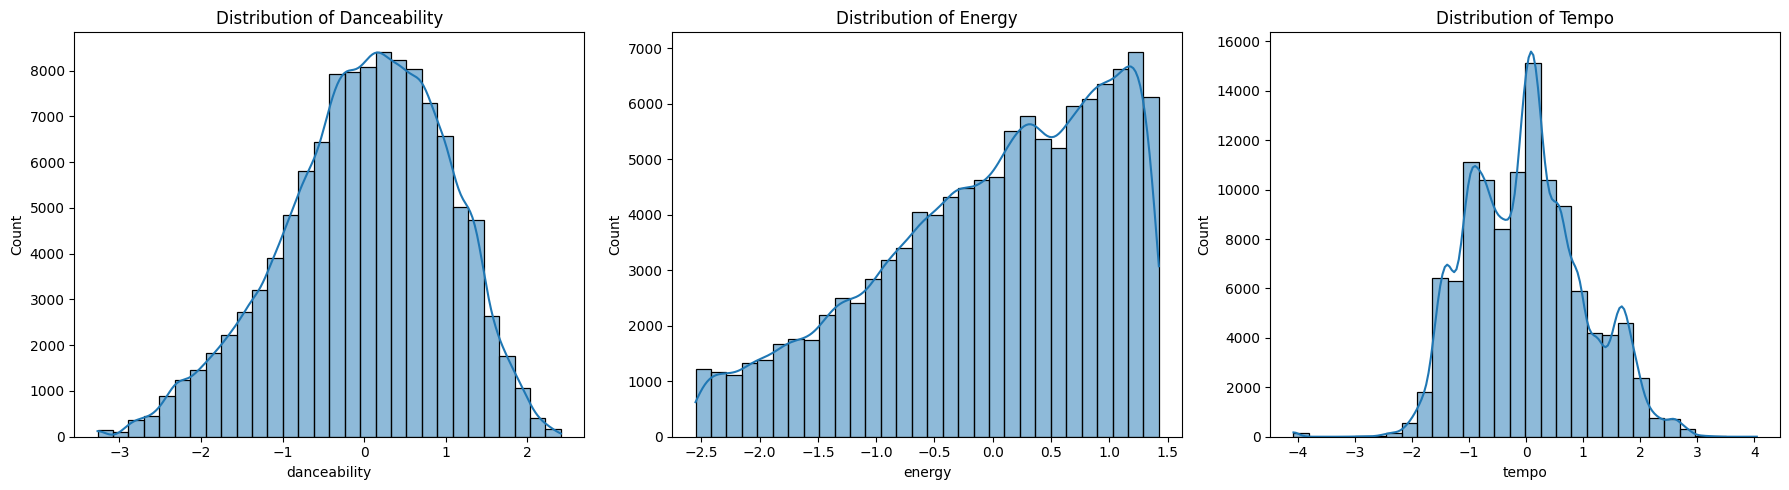

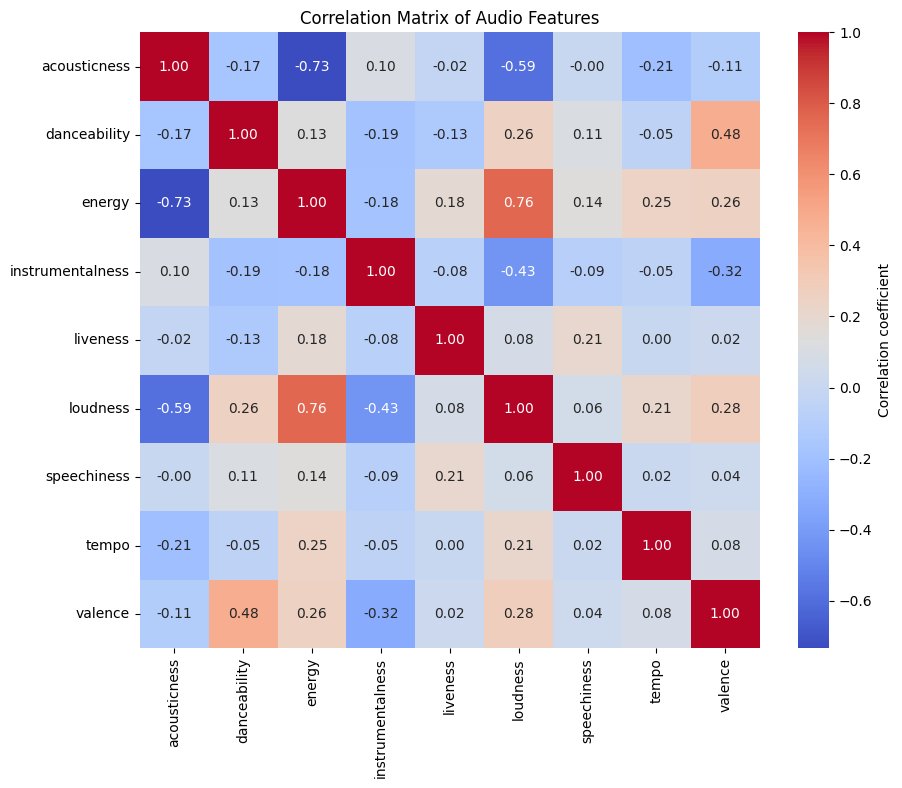

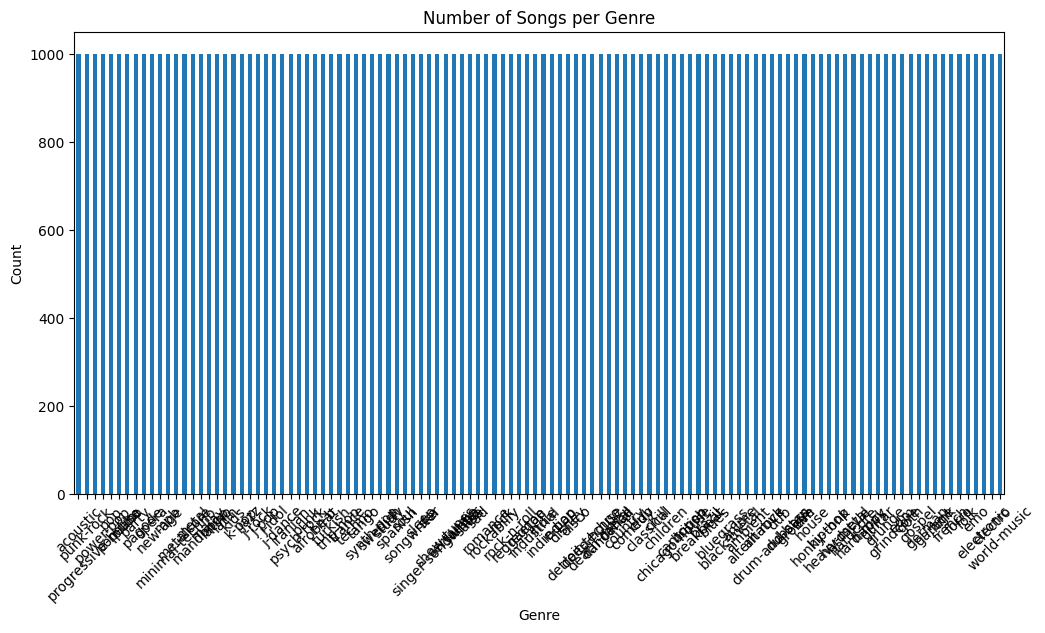

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
track_genre,,,,,,,,,
acoustic,0.757561,-0.099152,-0.819049,-0.380268,-0.316783,-0.236390,-0.391603,-0.104650,-0.193030
afrobeat,-0.132472,0.592248,0.244223,0.314753,-0.152102,0.093374,0.018223,-0.097888,0.866119
alt-rock,-0.579653,-0.186163,0.448418,-0.329354,-0.017356,0.411082,-0.279778,0.082946,0.170454
alternative,-0.502491,-0.039605,0.312677,-0.380840,-0.063960,0.433493,-0.137625,0.002821,0.082935
ambient,1.389018,-1.146311,-1.607055,1.680386,-0.442645,-2.056415,-0.407539,-0.368091,-1.182476
...,...,...,...,...,...,...,...,...,...
techno,-0.702197,0.677345,0.417567,1.240454,-0.284270,0.036006,-0.193324,0.203736,-0.587014
trance,-0.839160,0.095705,0.810599,0.863987,0.109280,0.383599,-0.046784,0.371233,-0.760575
trip-hop,-0.268539,0.391230,-0.075617,0.735610,-0.121919,-0.195047,-0.078964,-0.113557,0.015431


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random


audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
data = pd.read_csv("Dataset/dataset.csv")[audio_features + ['track_genre']]

# Normalize features
data[audio_features] = (data[audio_features] - data[audio_features].mean()) / data[audio_features].std()


# Set up the matplotlib figure
plt.figure(figsize=(18, 5))

# Titles of plots
features = ['danceability', 'energy', 'tempo']
titles = ['Distribution of Danceability', 'Distribution of Energy', 'Distribution of Tempo']

# Create a subplot for each feature
for i, feature in enumerate(features):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data[feature], bins=30, kde=True)
    plt.title(titles[i])

plt.tight_layout()
plt.savefig("png/pic1")
plt.show()




# Correlation matrix of audio features

correlation_matrix = data[audio_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation coefficient'})
plt.title('Correlation Matrix of Audio Features')
plt.savefig("png/pic2")
plt.show()


# Count of songs per genre
genre_counts = data['track_genre'].value_counts()

# Average features per genre
genre_means = data.groupby('track_genre')[audio_features].mean()

# Plotting the genre distribution
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title('Number of Songs per Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.savefig("png/pic3")
plt.show()

# Display the average features per genre
genre_means



In [50]:




gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Assuming 'data' is your DataFrame containing the Spotify dataset


def create_pairs(data, num_pairs=10000):
    pair_labels = []
    pair_data = []

    genre_list = data['track_genre'].unique()
    for _ in range(num_pairs):
        genre = random.choice(genre_list)
        genre_data = data[data['track_genre'] == genre]

        pos_indices = random.sample(range(len(genre_data)), 2)
        pair_data.append([genre_data.iloc[pos_indices[0]][audio_features].values, genre_data.iloc[pos_indices[1]][audio_features].values])
        pair_labels.append(1)

        neg_genre = random.choice([g for g in genre_list if g != genre])
        neg_data = data[data['track_genre'] == neg_genre]
        neg_index = random.choice(range(len(neg_data)))
        pair_data.append([genre_data.iloc[pos_indices[0]][audio_features].values, neg_data.iloc[neg_index][audio_features].values])
        pair_labels.append(0)

    return np.array(pair_data), np.array(pair_labels)







1 Physical GPUs, 1 Logical GPUs


In [40]:

def create_siamese_network(input_shape):
    base_input = Input(shape=input_shape)
    x = Dense(128, activation='relu')(base_input)
 
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    base_model = Model(inputs=base_input, outputs=x)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    processed_a = base_model(input_a)
    processed_b = base_model(input_b)
    # distance = Lambda(lambda tensors: tf.math.abs(tensors[0] - tensors[1]))([processed_a, processed_b])
    distance = Lambda(lambda embeddings: tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=1, keepdims=True) + tf.keras.backend.epsilon()))([processed_a, processed_b])
    outputs = Dense(1, activation='sigmoid')(distance)
    model = Model(inputs=[input_a, input_b], outputs=outputs)

    return model


def contrast_loss(y_true, y_pred, margin=1.0):
    square_pred = tf.square(y_pred)
    
    # Margin minus distance between the pairs (only applies when the pairs are dissimilar)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    
    # Calculate the loss
    loss = y_true * square_pred + (1 - y_true) * margin_square
    return tf.reduce_mean(loss)


In [51]:
# Setup the model#
input_shape = (len(audio_features),)
siamese_network = create_siamese_network(input_shape)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='accuracy'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]
# siamese_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
siamese_network.compile(optimizer='adam', loss='binary_crossentropy',metrics="accuracy")
print(siamese_network.summary())




Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 input_42 (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 model_26 (Functional)          (None, 32)           11616       ['input_41[0][0]',               
                                                                  'input_42[0][0]']               
                                                                                                  
 lambda_13 (Lambda)             (None, 1)            0           ['model_26[0][0]',        

In [7]:
# Generate and train the model
from sklearn.model_selection import train_test_split
pairs, labels = create_pairs(data)
pairs = pairs.astype('float32')
labels = labels.astype('float32')
pair_1 = pairs[:, 0]
pair_2 = pairs[:, 1]



In [52]:
X_train_1, X_test_1, X_train_2, X_test_2, y_train, y_test = train_test_split(pair_1, pair_2, labels, test_size=0.3, random_state=42)


In [53]:

from sklearn.metrics import accuracy_score
# Check shapes
print(pairs.shape)  # Should be something like (number_of_pairs, 2, number_of_features)
print(labels.shape)  # Should be (number_of_pairs,)
siamese_network.fit([X_train_1, X_train_2], y_train, batch_size=32, epochs=50,callbacks=callbacks)
# Evaluate the model
predictions = siamese_network.predict([X_test_1, X_test_2])
predicted_labels = (predictions > 0.5).astype(int)
test_accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {test_accuracy}")


# Now use pair_1 and pair_2 in model fitting
#siamese_network.fit([pair_1, pair_2], labels, epochs=10, batch_size=32)

(20000, 2, 9)
(20000,)
Epoch 1/50
438/438 [==============================] - 3s 5ms/step - loss: 0.8358 - accuracy: 0.4623
Epoch 2/50
438/438 [==============================] - 2s 5ms/step - loss: 0.7469 - accuracy: 0.4804
Epoch 3/50
438/438 [==============================] - 2s 5ms/step - loss: 0.7381 - accuracy: 0.4886
Epoch 4/50
438/438 [==============================] - 2s 5ms/step - loss: 0.7314 - accuracy: 0.4984
Epoch 5/50
438/438 [==============================] - 2s 4ms/step - loss: 0.7233 - accuracy: 0.5105
Epoch 6/50
438/438 [==============================] - 2s 4ms/step - loss: 0.7148 - accuracy: 0.5171
Epoch 7/50
438/438 [==============================] - 2s 5ms/step - loss: 0.7091 - accuracy: 0.5288
Epoch 8/50
438/438 [==============================] - 2s 5ms/step - loss: 0.7052 - accuracy: 0.5358
Epoch 9/50
438/438 [==============================] - 2s 5ms/step - loss: 0.7023 - accuracy: 0.5402
Epoch 10/50
438/438 [==============================] - 2s 5ms/step - loss: 0.

In [16]:
# """def recommend_similar_song(data, song_index, model, audio_features):
#     # Extract the features of the given song
#     song_features = data.iloc[song_index][audio_features].values.reshape(1, -1)
#     song_features = song_features.astype('float32')

#     # Initialize an array to store the similarities
#     similarities = []

#     # Compare with every other song
#     for i in range(10000):
#         if i != song_index:
#             comparison_song_features = data.iloc[i][audio_features].values.reshape(1, -1)
#             comparison_song_features = comparison_song_features.astype('float32')

#             # The model expects two inputs, so we provide the song and each comparison song as pairs
#             similarity = model.predict([song_features, comparison_song_features])
#             similarities.append((similarity[0][0], i))

#     # Sort by similarity (distance), the lower the more similar

#     similarities.sort(reverse=True, key=lambda x: x[0])


#     # Return the most similar song's index and similarity score
#     return similarities[0]
# # Example usage
# # Let's say you want to find a song similar to the song at index 100 in your dataset
# most_similar = recommend_similar_song(data, 100, siamese_network, audio_features)
# similar_song_index = most_similar[1]
# print("Most similar song index:", similar_song_index)
# print("Song details:", data.iloc[similar_song_index])
# """

In [11]:
def recommend_similar_song(data, song_index, model, audio_features, batch_size=100):
    # Extract the features of the given song
    song_features = data.iloc[song_index][audio_features].values.reshape(1, -1)
    song_features = song_features.astype('float32')

    similarities = []

    # Batch processing
    num_songs = len(data)
    for i in range(0, num_songs, batch_size):
        end_index = min(i + batch_size, num_songs)
        batch_indices = [index for index in range(i, end_index) if index != song_index]
        comparison_song_features = data.iloc[batch_indices][audio_features].values.astype('float32')

        # The model expects two inputs; replicate the song_features to match the batch size
        song_features_batch = np.tile(song_features, (len(batch_indices), 1))

        # Compute similarities in a batch
        batch_similarities = model.predict([song_features_batch, comparison_song_features])
        
        # Collect results
        for j, similarity in enumerate(batch_similarities):
            similarities.append((similarity[0], batch_indices[j]))

    # Sort by similarity (the higher the more similar)
    similarities.sort(reverse=True, key=lambda x: x[0])

    # Return the most similar song's index and similarity score
    return similarities[0]


In [12]:
song_index = 100
recommended_song_info = recommend_similar_song(data, song_index, siamese_network, audio_features)



4/4 [==============================] - 0s 2ms/step


KeyboardInterrupt: 

In [ ]:
datas = pd.read_csv("dataset.csv")

datas = datas["artists"]

datas.head(5)

0               Gen Hoshino
1              Ben Woodward
2    Ingrid Michaelson;ZAYN
3              Kina Grannis
4          Chord Overstreet
Name: artists, dtype: object

In [ ]:
print("Recommended Song Details:"," ",datas[recommended_song_info[0]])

print(data.iloc[recommended_song_info[1]],end="\n\n\n")  # recommended_song_info[1] holds the index of the most similar song

print("Song given for Recommendation:",datas[100],"\n",data.iloc[100])

KeyError: 'key of type tuple not found and not a MultiIndex'

In [32]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# Assuming `model` is your trained Siamese model
# Assuming `pair_1_test` and `pair_2_test` are your test datasets
# Assuming `labels_test` are the true binary labels for the test set

# Predict distances
distances = siamese_network.predict([X_test_1, X_test_2])

# Convert distances to binary labels based on a threshold
threshold = 0.5  # This threshold can be tuned
predictions = (distances < threshold).astype(int)

# Calculate F1-score, precision, and recall
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print("Precision:", precision*100,"%")
print("Recall:", recall*100,"%")
print("F1-score:", f1*100,"%")


188/188 [==============================] - 0s 2ms/step
Precision: 39.03265557609365 %
Recall: 41.76005273566249 %
F1-score: 40.35031847133758 %
